# Script for electricity demand projection and downscaling

In [1]:
import pandas as pd
import world_bank_data as wb
import numpy as np
import matplotlib.pyplot as plt
import urllib
import xlsxwriter
from sklearn.linear_model import LinearRegression

## Input data and projection boundaries

### Imports relevant input data

In [15]:
#Imports model memberships
Import_memberships = pd.read_csv(r'data/OPG_memberships_19-03-2020.csv')

#Imports SSP GDPppp and Population projections (https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=30)
Import_iamc_db_GDPppp_Countries = pd.read_excel(r'data/iamc_db_GDPppp_Countries.xlsx')
Import_iamc_db_POP_Countries = pd.read_excel(r'data/iamc_db_POP_Countries.xlsx')
Import_iamc_db_URB_Countries = pd.read_excel(r'data/iamc_db_URB_Countries.xlsx')

#Imports custom GDPppp and Population projections for countries not included in the SSP datasets.
Import_POP_Missing = pd.read_excel(r'data/iamc_db_POP_GDPppp_URB_Countries_Missing.xlsx' , 
                                   sheet_name = 'POP').set_index('Region')

Import_GDP_Missing = pd.read_excel(r'data/iamc_db_POP_GDPppp_URB_Countries_Missing.xlsx' , 
                                   sheet_name = 'GDP|PPP').set_index('Region')

Import_URB_Missing = pd.read_excel(r'data/iamc_db_POP_GDPppp_URB_Countries_Missing.xlsx' , 
                                   sheet_name = 'URB').set_index('Region')

#Imports T&D losses projections (https://www.sciencedirect.com/science/article/pii/S0142061518335075?via%3Dihub)
Import_Incl_Losses = pd.read_excel(r'data/T&D Losses.xlsx')

Import_iamc_db_GDPppp_Countries.head(2)

,Model,Scenario,Region,Variable,Unit,2010,2015,2020,2025,2030,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Notes
0,OECD Env-Growth,SSP1,ABW,GDP|PPP,billion US$2005/yr,0.151,0.205,0.266,0.357,0.492,...,2.586,3.165,3.797,4.470,5.171,5.842,6.469,7.034,7.505,NaN
1,OECD Env-Growth,SSP2,ABW,GDP|PPP,billion US$2005/yr,0.151,0.205,0.264,0.342,0.442,...,1.762,2.161,2.621,3.138,3.711,4.314,4.951,5.615,6.301,NaN


### Retrieves PLEXOS-World 2015 hourly demand data incl. T&D losses for all nodes
Used to be able to disaggregate regional electricity demand to the nodal level as well as calculate relative peak demand per node.

In [3]:
#Checks whether the All Demand UTC 2015.csv datafile needs to be retrieved from the PLEXOS-World Harvard Dataverse or whether
#the file already exists in the local folder.
try:
    Open = open(r'data/All Demand UTC 2015.csv')
    Import_Hourly_Demand_2015 = pd.read_csv(r'data/All Demand UTC 2015.csv')
    
except IOError:
    urllib.request.urlretrieve ('https://dataverse.harvard.edu/api/access/datafile/3985039?format=original&gbrecs=true', 
                            r'data/All Demand UTC 2015.csv')
    Import_Hourly_Demand_2015 = pd.read_csv(r'data/All Demand UTC 2015.csv')
    
Import_Hourly_Demand_2015.head(2)

,Datetime,EU-AUT,EU-BEL,EU-BGR,EU-BIH,EU-CHE,EU-CYP,EU-CZE,EU-DEU,EU-DNK,...,OC-FJI,OC-PNG,SA-BOL,SA-COL,SA-ECU,SA-GUF,SA-GUY,SA-PRY,SA-SUR,SA-VEN
0,01/01/2015,7847,10281,5267,1749,8205,437,6931,54544,3382,...,126,550,1300,9541,3911,39,136,2626,270,16344
1,01/01/2015 01:00,7480,9785,5032,1658,8214,413,6816,52795,3301,...,125,544,1197,9215,3973,38,121,2514,266,14925


### Set boundaries for the regression

In [16]:
#Set the spatial resolution for the regession, either on 'Country' level or on continental level by setting 'child_object'. 
#Note that not all countries have historical data available so country-level regression can't be applied for all and will
#result in errors for now.
Spatial_Resolution = 'child_object'

#Include urbanization as part of the regression? 'Yes' or 'No'
Urbanization = 'No'

#Set which SSP data and sources are to be used for the country-level GDP|PPP and Population projects.
Pathway = 'SSP2'
POP_Countries_Source = 'IIASA-WiC POP' #Options are 'IIASA-WiC POP' and 'NCAR'
GDPppp_Countries_Source = 'OECD Env-Growth' #Options are 'IIASA GDP' and 'OECD Env-Growth'. 'OECD Env-Growth' has more entries.
URB_Countries_Source = 'NCAR'

#Set modelling years
Years_List = np.arange(2010, 2105, 5).tolist()

In [17]:
Spatial_Mapping = Import_memberships.copy()
Spatial_Mapping = Spatial_Mapping[Spatial_Mapping['collection'].str.contains('Region')]
Spatial_Mapping['Country'] = Spatial_Mapping.parent_object.str.split('-' , expand = True)[1]

Spatial_Mapping_Country = Spatial_Mapping.copy().set_index('Country')
Spatial_Mapping_Country = Spatial_Mapping_Country.loc[~Spatial_Mapping_Country.index.duplicated(keep='first')]

Spatial_Mapping_Node = Spatial_Mapping.copy().set_index('parent_object')
Spatial_Mapping_Node = Spatial_Mapping_Node.loc[~Spatial_Mapping_Node.index.duplicated(keep='first')]
               
Spatial_Mapping_Node.head(1)

,parent_class,child_class,collection,child_object,Country
parent_object,,,,,
AF-AGO,Country,Continents,Region,Africa,AGO


## Historical relationships

### Creates historic GDP|PPP pp / Demand pp relationships based on World Bank Data

In [18]:
#Extracts historical GDPppp per capita (constant 2017 international $) from the World Bank API
Country_GDPppp_WB = wb.get_series('NY.GDP.PCAP.PP.KD', 
                                  date = '1980:2014' , 
                                  id_or_value = 'id')

Country_GDPppp_WB = Country_GDPppp_WB.reset_index().rename(columns = 
                                                           {'NY.GDP.PCAP.PP.KD' : 
                                                            'WB_GDPppp'}
                                                          ).set_index('Country')

#Extracts Electricity consumption per capita in kWh from the World Bank API. Data available for up till 2014
Country_Elec_WB = wb.get_series('EG.USE.ELEC.KH.PC', 
                                date = '1980:2014' , 
                                id_or_value = 'id')

Country_Elec_WB = Country_Elec_WB.reset_index().rename(columns = 
                                                       {'EG.USE.ELEC.KH.PC' : 
                                                        'WB_Elec'}
                                                      ).set_index('Country')

#Extracts Urban population (% of total population) from the World Bank API.
Country_Urb_WB = wb.get_series('SP.URB.TOTL.IN.ZS', 
                               date = '1980:2014' , 
                               id_or_value = 'id')

Country_Urb_WB = Country_Urb_WB.reset_index().rename(columns = 
                                                     {'SP.URB.TOTL.IN.ZS' : 
                                                      'WB_Urb'}
                                                    ).set_index('Country')

Country_Urb_WB.tail(1)

,Series,Year,WB_Urb
Country,,,
ZWE,SP.URB.TOTL.IN.ZS,2014,32.504


In [19]:
#Merges the relevant dataframes
Country_Regression_WB = pd.merge(Country_GDPppp_WB[['Year' , 
                                                     'WB_GDPppp']] , 
                                  Country_Elec_WB[['Year' , 
                                                   'WB_Elec']] , 
                                  left_on = ['Year' , 
                                             'Country'] , 
                                  right_on = ['Year' , 
                                              'Country'])

if Urbanization == 'Yes':
    Country_Regression_WB = pd.merge(Country_Regression_WB[['Year' , 
                                                            'WB_GDPppp' , 
                                                            'WB_Elec']] , 
                                     Country_Urb_WB[['Year' , 
                                                     'WB_Urb']] , 
                                  left_on = ['Year' , 
                                             'Country'] , 
                                  right_on = ['Year' , 
                                              'Country'])

#Drops all entries that don't have an inner match
Country_Regression_WB = Country_Regression_WB.dropna()

Country_Regression_WB = pd.merge(Country_Regression_WB, 
                                  Spatial_Mapping_Country[['parent_object' , 
                                                           'child_object']] , 
                                  left_index = True , 
                                  right_index = True)

Country_Regression_WB = Country_Regression_WB.set_index(Spatial_Resolution)

#Groups the entries by <Spatial_Resolution> and calculates the regional linear fit based on all historical values 

sklearn_lr = LinearRegression()
Country_Regression_WB_Grouped = pd.DataFrame()

for x in Country_Regression_WB.index.unique():
    
    Country_Regression_WB_Temp = Country_Regression_WB.copy().loc[x]
    
    if Urbanization == 'Yes':
        
        sklearn_lr.fit(Country_Regression_WB_Temp[['WB_GDPppp' , 
                                                   'WB_Urb']] , 
                       Country_Regression_WB_Temp['WB_Elec'])
        
        Country_Regression_WB_Temp['intercept'
                                  ] ,  Country_Regression_WB_Temp['coef_GDPppp'
                                                                 ] ,  Country_Regression_WB_Temp['coef_Urb'
                                                                                                ] = [sklearn_lr.intercept_ , 
                                                                                                float(sklearn_lr.coef_[0]) , 
                                                                                               float(sklearn_lr.coef_[1])]
        
        Country_Regression_WB_Grouped = Country_Regression_WB_Grouped.append(Country_Regression_WB_Temp)
        
    else:
        
        sklearn_lr.fit(Country_Regression_WB_Temp[['WB_GDPppp']], 
                       Country_Regression_WB_Temp['WB_Elec'])
              
        Country_Regression_WB_Temp['intercept'
                                  ] ,  Country_Regression_WB_Temp['coef_GDPppp'] = [sklearn_lr.intercept_ , 
                                                                                    float(sklearn_lr.coef_)]
        
        Country_Regression_WB_Grouped = Country_Regression_WB_Grouped.append(Country_Regression_WB_Temp)
        
        
Country_Regression_WB_Grouped

,Year,WB_GDPppp,WB_Elec,parent_object,intercept,coef_GDPppp
child_object,,,,,,
Africa,1990,5758.320989,53.171799,AF-AGO,-79.314642,0.139140
Africa,1991,5625.254267,54.453865,AF-AGO,-79.314642,0.139140
Africa,1992,5125.902292,53.486642,AF-AGO,-79.314642,0.139140
Africa,1993,3772.060746,52.007453,AF-AGO,-79.314642,0.139140
Africa,1994,3701.228371,50.652608,AF-AGO,-79.314642,0.139140
...,...,...,...,...,...,...
North America,2010,54437.083453,13395.139932,NA-USA-AK,-1834.961780,0.332004
North America,2011,54884.707368,13247.013128,NA-USA-AK,-1834.961780,0.332004
North America,2012,55712.705832,12966.115934,NA-USA-AK,-1834.961780,0.332004


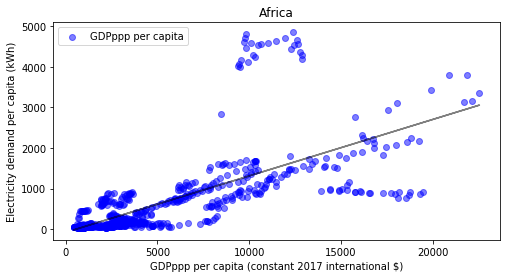

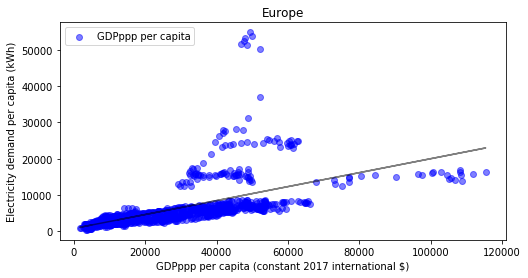

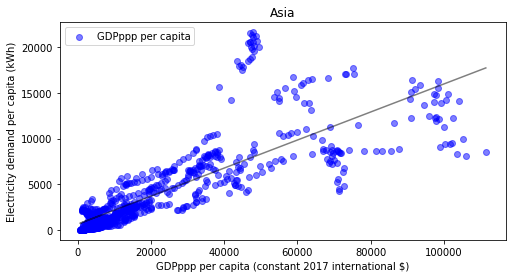

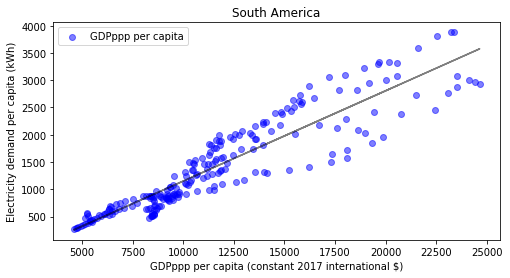

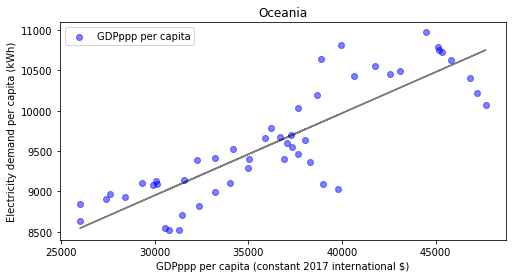

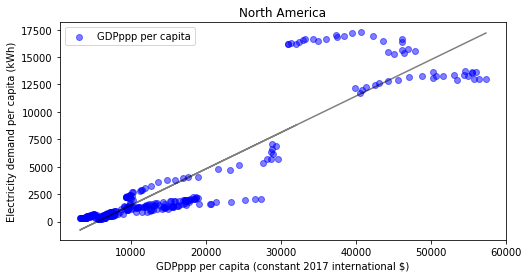

In [20]:
for a in Country_Regression_WB_Grouped.index.unique():
    Country_Regression_WB_plot = Country_Regression_WB_Grouped.loc[a]
    b = Country_Regression_WB_plot['WB_GDPppp']
    c = Country_Regression_WB_plot['WB_Elec']
    x = Country_Regression_WB_plot.loc[a , 'WB_GDPppp']
    m = Country_Regression_WB_plot.loc[a , 'coef_GDPppp']
    z = Country_Regression_WB_plot.loc[a , 'intercept']
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(b , c , color = 'blue' , alpha = 0.5 , label = 'GDPppp per capita')
    
    if Urbanization == 'Yes':
        
        m2 = Country_Regression_WB_plot.loc[a , 'coef_Urb']
        x2 = Country_Regression_WB_plot.loc[a , 'WB_Urb']
        d = Country_Regression_WB_plot['WB_Urb']
        ax2 = ax1.twiny()
        ax2.scatter(d , c , color = 'red' , alpha = 0.5 , label = 'Urban population') 
        ax2.set_xlabel('Urban population (% of total population)')
        ax2.legend(loc = 'upper right')
        
    else:
        plt.plot(x , m * x + z , color = 'black' , alpha = 0.5)
    
    ax1.legend(loc='upper left')
    ax1.set_xlabel('GDPppp per capita (constant 2017 international $)')
    ax1.set_ylabel('Electricity demand per capita (kWh)')
    plt.title(a)
    plt.rcParams["figure.figsize"] = [8,4]
    plt.show()

## Country-level Projections

### Creates dataframe with SSP specific population projections

In [21]:
#Filters relevant data based on earlier given entries (SSP Pathway and source for POP)
Country_POP_SSP = Import_iamc_db_POP_Countries.loc[(Import_iamc_db_POP_Countries['Model'] == 
                                                    POP_Countries_Source) 
                                                   & (Import_iamc_db_POP_Countries['Scenario'] == 
                                                      Pathway)
                                                  ].set_index('Region')

#Checks whether pathway data is available for all included countries. In case pathway data is not available for all countries 
#it checks wheter custom data is provided in 'iamc_db_POP_POP_Countries_Missing.xlsx'. If not, an error POPs up indicating 
#for which countries data is missing. Data has to be manually added to project demand for all countries.
Country_POP_SSP_Missing = Spatial_Mapping_Country[(~Spatial_Mapping_Country.index.isin
                                                   (Country_POP_SSP.index))]

for x in Country_POP_SSP_Missing.index:
    a = x in Import_POP_Missing.index
    if a == False:
        raise SystemExit(f'Country data for {x} is not available in the SSP or custom dataset! Add country-level data.')
    else: 
        print(f'Country data for {x} included from custom dataset.')

#Filters data for relevant SSP
Import_POP_Missing = Import_POP_Missing.loc[(Import_POP_Missing['Scenario'] == Pathway)]

#Appends both dataframes
Country_POP_SSP = Country_POP_SSP.append(Import_POP_Missing, ignore_index = False)

#Filters data for relevant to be modelled countries
Country_POP_SSP = pd.merge(Spatial_Mapping_Country[['child_object']] , 
                           Country_POP_SSP , 
                           left_index = True , 
                           right_index = True , 
                           how = 'inner')

Country_POP_SSP.head(2)

Country data for ESH included from custom dataset.
Country data for TWN included from custom dataset.
Country data for KOS included from custom dataset.
Country data for ATA included from custom dataset.


,child_object,Model,Scenario,Variable,Unit,2010,2015,2020,2025,2030,...,2070,2075,2080,2085,2090,2095,2100,Notes,Source_1,Source_2
AGO,Africa,IIASA-WiC POP,SSP2,Population,million,19.081912,22.012692,25.239158,28.561240,31.855157,...,52.597806,53.996634,55.141770,56.029632,56.598233,56.880847,56.891920,NaN,NaN,NaN
BDI,Africa,IIASA-WiC POP,SSP2,Population,million,8.382244,9.642009,10.892054,12.037282,13.085824,...,18.937831,19.188124,19.323814,19.352648,19.289082,19.148876,18.917913,NaN,NaN,NaN


### Creates dataframe with SSP specific GDP|PPP projections

In [22]:
#Filters relevant data based on earlier given entries (SSP Pathway and source for GDPppp)
Country_GDPppp_SSP = Import_iamc_db_GDPppp_Countries.loc[(Import_iamc_db_GDPppp_Countries['Model'] == 
                                                          GDPppp_Countries_Source) & 
                                                         (Import_iamc_db_GDPppp_Countries['Scenario'] == 
                                                          Pathway)
                                                        ].set_index('Region')

#Checks whether pathway data is available for all included countries. In case pathway data is not available for all countries 
#it checks wheter custom data is provided in 'iamc_db_GDPppp_GDPppp_Countries_Missing.xlsx'. If not, an error GDPppps up 
#indicating for which countries data is missing. Data has to be manually added to project demand for all countries.
Country_GDPppp_SSP_Missing = Spatial_Mapping_Country[(~Spatial_Mapping_Country.index.isin(Country_GDPppp_SSP.index))]

for x in Country_GDPppp_SSP_Missing.index:
    a = x in Import_GDP_Missing.index
    if a == False:
        raise SystemExit(f'Country data for {x} is not available in the SSP or custom dataset! Add country-level data.')
    else: 
        print(f'Country data for {x} included from custom dataset.')

#Filters data for relevant SSP
Import_GDP_Missing = Import_GDP_Missing.loc[(Import_GDP_Missing['Scenario'] == Pathway)]

#Appends both dataframes
Country_GDPppp_SSP = Country_GDPppp_SSP.append(Import_GDP_Missing, ignore_index = False)

#Filters data for relevant to be modelled countries
Country_GDPppp_SSP = pd.merge(Spatial_Mapping_Country[['child_object']] , 
                              Country_GDPppp_SSP , 
                              left_index = True , 
                              right_index = True , 
                              how = 'inner')

Country_GDPppp_SSP.head(2)

Country data for ESH included from custom dataset.
Country data for PRK included from custom dataset.
Country data for KOS included from custom dataset.
Country data for ATA included from custom dataset.
Country data for GUF included from custom dataset.


,child_object,Model,Scenario,Variable,Unit,2010,2015,2020,2025,2030,...,2070,2075,2080,2085,2090,2095,2100,Notes,Source_1,Source_2
AGO,Africa,OECD Env-Growth,SSP2,GDP|PPP,billion US$2005/yr,98.686,128.679,172.787,200.062,218.446,...,747.486,919.388,1119.581,1347.305,1601.584,1881.075,2184.172,NaN,NaN,NaN
BDI,Africa,OECD Env-Growth,SSP2,GDP|PPP,billion US$2005/yr,4.389,5.761,8.010,11.189,15.805,...,187.890,239.530,299.300,367.433,444.559,530.695,624.595,NaN,NaN,NaN


### Creates dataframe with SSP specific urban population projections

In [23]:
#Filters relevant data based on earlier given entries (SSP Pathway and source for URB)
Country_URB_SSP = Import_iamc_db_URB_Countries.loc[(Import_iamc_db_URB_Countries['Model'] == 
                                                          URB_Countries_Source) & 
                                                         (Import_iamc_db_URB_Countries['Scenario'] == 
                                                          Pathway)
                                                        ].set_index('Region')

#Checks whether pathway data is available for all included countries. In case pathway data is not available for all countries 
#it checks wheter custom data is provided in 'iamc_db_URB_URB_Countries_Missing.xlsx'. If not, an error URBs up 
#indicating for which countries data is missing. Data has to be manually added to project demand for all countries.
Country_URB_SSP_Missing = Spatial_Mapping_Country[(~Spatial_Mapping_Country.index.isin(Country_URB_SSP.index))]

for x in Country_URB_SSP_Missing.index:
    a = x in Import_URB_Missing.index
    if a == False:
        raise SystemExit(f'Country data for {x} is not available in the SSP or custom dataset! Add country-level data.')
    else: 
        print(f'Country data for {x} included from custom dataset.')

#Filters data for relevant SSP
Import_URB_Missing = Import_URB_Missing.loc[(Import_URB_Missing['Scenario'] == Pathway)]

#Appends both dataframes
Country_URB_SSP = Country_URB_SSP.append(Import_URB_Missing, ignore_index = False)

#Filters data for relevant to be modelled countries
Country_URB_SSP = pd.merge(Spatial_Mapping_Country[['child_object']] , 
                              Country_URB_SSP , 
                              left_index = True , 
                              right_index = True , 
                              how = 'inner')

Country_URB_SSP.head(2)

Country data for ESH included from custom dataset.
Country data for TWN included from custom dataset.
Country data for KOS included from custom dataset.
Country data for ATA included from custom dataset.


,child_object,Model,Scenario,Variable,Unit,2010,2015,2020,2025,2030,...,2070,2075,2080,2085,2090,2095,2100,Notes,Source_1,Source_2
AGO,Africa,NCAR,SSP2,Population|Urban|Share,%,58.504,62.276328,65.454937,68.136581,70.407990,...,80.283708,80.945817,81.538027,82.069760,82.548891,82.982040,83.374805,NaN,NaN,NaN
BDI,Africa,NCAR,SSP2,Population|Urban|Share,%,10.999,12.838025,14.876755,17.105696,19.507284,...,41.123810,43.636425,46.031740,48.301427,50.441472,52.451347,54.333206,NaN,NaN,NaN


### Projects electricity demand by making use of historic relationships and SSP specific Population, GDP|PPP and optionally urbanization projections

In [24]:
#Creates base dataframe for demand projections with the required coefficients
Base_df_projections = Country_GDPppp_SSP[['child_object' , 
                                          'Scenario']]

Regression_Coefficients = Country_Regression_WB_Grouped.loc[~Country_Regression_WB_Grouped.index.duplicated(keep = 'first')]

if Urbanization == 'Yes':
    w = ['coef_GDPppp' , 
         'coef_Urb' , 
         'intercept']
else:
    w = ['coef_GDPppp' , 
         'intercept']
    
#Divides the country level GDP|PPP data (converted from billions to millions) with the population (millions) to get GDP|PPP pp.
Country_GDPppp_pp_SSP = pd.merge(Base_df_projections , 
                           Regression_Coefficients[w] , 
                           left_on = 'child_object' , 
                           right_index = True , 
                           how = 'left')

for x in Years_List:
    Country_GDPppp_pp_SSP[x] = (Country_GDPppp_SSP[x] * 1000) / Country_POP_SSP[x]
    
if Urbanization == 'Yes':
    y = ['child_object' , 
         'Scenario' , 
         'coef_GDPppp' ,
         'coef_Urb' ,
         'intercept']
else:
    y = ['child_object' , 
             'Scenario' , 
             'coef_GDPppp' ,
             'intercept']
    
#Applies the country-level GDP|PPP pp values to a linear regression to project country-level electricity demand pp.
Country_Demand_projected_SSP = Country_GDPppp_pp_SSP.copy([[y]])

Country_Demand_projected_SSP['Variable'] = 'Demand|projected|pp'

if Urbanization == 'Yes':
    for z in Years_List:
         Country_Demand_projected_SSP[z] = (Country_Demand_projected_SSP['coef_GDPppp'] * 
                                            Country_GDPppp_pp_SSP[z] + 
                                            Country_Demand_projected_SSP['coef_Urb'] * 
                                            Country_URB_SSP[z] + 
                                            Country_Demand_projected_SSP['intercept'])
else:
    for z in Years_List:
         Country_Demand_projected_SSP[z] = (Country_Demand_projected_SSP['coef_GDPppp'] * 
                                            Country_GDPppp_pp_SSP[z] + 
                                            Country_Demand_projected_SSP['intercept'])
        
Country_Demand_projected_SSP.head(2)

,child_object,Scenario,coef_GDPppp,intercept,2010,2015,2020,2025,2030,2035,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Variable
AGO,Africa,SSP2,0.13914,-79.314642,640.278111,734.054419,873.238726,895.317358,874.837139,826.498998,...,1306.074878,1571.446867,1898.058172,2289.795574,2745.747067,3266.495379,3857.998614,4522.119176,5262.506783,Demand|projected|pp
BDI,Africa,SSP2,0.13914,-79.314642,-6.459807,3.820272,23.008970,50.020325,88.738469,140.257456,...,761.069205,1003.459681,1301.153996,1657.608190,2075.783214,2562.430271,3127.478615,3776.843401,4514.552241,Demand|projected|pp


In [26]:
for a in Spatial_Mapping_Country['child_object'].unique():
    Country_Regression_WB_plot = Country_Regression_WB.loc[a]
    
    Country_GDPppp_pp_SSP_plot = Country_GDPppp_pp_SSP.loc[(Country_GDPppp_pp_SSP['child_object'] == a)]
    
    Country_Demand_projected_SSP_plot = Country_Demand_projected_SSP.loc[(Country_Demand_projected_SSP['child_object'
                                                                                                         ] == a)]
    x = Country_Regression_WB_plot['WB_GDPppp']
    x2 = Country_GDPppp_pp_SSP_plot[2035]
    x3 = Country_GDPppp_pp_SSP_plot[2050]
    x4 = Country_GDPppp_pp_SSP_plot[2100]
    y = Country_Regression_WB_plot['WB_Elec']
    y2 = Country_Demand_projected_SSP_plot[2035]
    y3 = Country_Demand_projected_SSP_plot[2050]
    y4 = Country_Demand_projected_SSP_plot[2100]
    m = Country_Regression_WB_plot['slope'].unique()
    b = Country_Regression_WB_plot['intercept'].unique()
    plt.scatter(x , y , color = 'grey' , alpha = 0.5 , label = '1980-2014 (World Bank)')
    plt.scatter(x2 , y2 , color = 'green' , alpha = 0.5 , label = '2035')
    plt.scatter(x3 , y3 , color = 'blue' , alpha = 0.5 , label = '2050')
    plt.scatter(x4 , y4 , color = 'red' , alpha = 0.5 , label = '2100')
    plt.legend(loc='upper left')
    plt.plot(x , m * x + b , color = 'black' , alpha = 0.5)
    plt.plot(x2 , m * x2 + b , color = 'black' , alpha = 0.5)
    plt.plot(x3 , m * x3 + b , color = 'black' , alpha = 0.5)
    plt.plot(x4 , m * x4 + b , color = 'black' , alpha = 0.5)
    plt.title(f'Demand projection {a}')
    plt.xlabel('GDPppp per capita (constant 2017 international $)')
    plt.ylabel('Electricity demand per capita (kWh)')
    plt.show()

KeyError: 'coef_GDPppp'

### Aggregates projected demand per person to full country-level

In [28]:
#Multiplies the country-level projected demand pp (in kWh) with the total population (in millions) to get country-level 
#total projected demand (in GWh).
Country_Demand_projected_SSP_Aggregated = pd.DataFrame()
for x in Years_List:
     Country_Demand_projected_SSP_Aggregated[x] = (Country_Demand_projected_SSP[x] * 
                                                   Country_POP_SSP[x]).round(2)

Country_Demand_projected_SSP_Aggregated.head(2)

,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
AGO,12217.73,16158.51,22039.81,25571.37,27868.07,28964.47,31027.66,35077.70,41707.48,51181.56,63809.42,79935.29,99833.70,123641.25,151405.35,183020.53,218355.91,257221.97,299394.12
BDI,-54.15,36.84,250.61,602.11,1161.22,1975.62,3163.97,4819.58,7042.40,9973.52,13795.02,18643.19,24641.03,31806.39,40112.05,49589.81,60326.19,72322.31,85405.91


### Adds transmission and distribution losses to country-level demand
Explicit modelling of domestic transmission and distribution is not incorporated in PLEXOS-World. Country-level T&D losses per 5-year interval are added to the projected electricity demand based on Sadovskaia et al., 2019; https://doi.org/10.1016/j.ijepes.2018.11.012. Study includes data for up till 2050. 5-year intervals after that are manually added (Maarten Brinkerink) and values kept equal compared to 2050.

In [29]:
#Checks whether T&D is available for all included countries. An assertion error pops up in case data is missing. 
#In this case either data needs to be added to 'T&D Losses.xlsx'.
Losses_Missing = Spatial_Mapping_Country[(~Spatial_Mapping_Country.index.isin(Import_Incl_Losses.Country))]

assert Losses_Missing.empty , print(Losses_Missing)

Country_Demand_Incl_Losses = Import_Incl_Losses.copy().set_index('Country')

Country_Demand_Incl_Losses = Country_Demand_Incl_Losses[Country_Demand_Incl_Losses.index.isin
                                                        (Spatial_Mapping_Country.index)
                                                       ].reindex(Spatial_Mapping_Country.index)

Country_Demand_projected_SSP_Incl_Losses = pd.DataFrame()

#Add T&D losses to the projected country-level demand.
for z in Years_List:
     Country_Demand_projected_SSP_Incl_Losses[z] = (Country_Demand_projected_SSP_Aggregated[z] * 
                                                    Country_Demand_Incl_Losses[z] / 100 + 
                                                    Country_Demand_projected_SSP_Aggregated[z]
                                                   ).round(2)

Country_Demand_projected_SSP_Incl_Losses.head(2)

,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
AGO,13921.44,18310.77,24734.30,28368.56,30534.32,31360.68,33256.32,37426.61,44370.34,54449.31,67883.41,85038.85,106207.70,131535.27,161072.00,194705.69,232297.10,273644.61,318509.29
BDI,-116.70,77.61,511.64,1171.43,2085.00,3086.68,4102.58,5562.60,7650.89,10835.27,14986.96,20254.03,26770.11,34554.58,43577.88,53874.55,65538.59,78571.22,92785.29


## Downscaling from country-level to nodal-level

### Determines relative 2015 share of demand per sub-country node

In [30]:
#Sums the hourly demand as retrieved from the PLEXOS-World dataset to year total (in MWh) and drops all hourly values.
Demand_2015_Raw = Import_Hourly_Demand_2015.drop(columns = ['Datetime'])

Demand_2015_Raw.loc['Node_Demand_2015'] = Demand_2015_Raw.sum()

Demand_2015_Raw = Demand_2015_Raw.iloc[8760:]

#Transposes the dataframe and uses the original headers as column entry. 
Demand_2015_Raw = Demand_2015_Raw.transpose().reset_index().rename(columns = {'index' : 
                                                                              'PLEXOS_Nodes'})

#Adds country entry to dataframe (e.g. NA-USA-CA Node gets column entry NA-USA country)
Demand_2015_Raw.insert(loc = 0 , 
                       column = 'Country' , 
                       value  = Demand_2015_Raw.PLEXOS_Nodes.str.split('-' , expand = True)[1])

Demand_2015_Raw.insert(loc = 1 , 
                       column = 
                       'PLEXOS_Countries' , 
                       value = Demand_2015_Raw['PLEXOS_Nodes'].str[:6])

#Creates a dataframe excluding all sub-country nodes
Country_Demand_2015 = Demand_2015_Raw[Demand_2015_Raw['PLEXOS_Countries'] == 
                                      Demand_2015_Raw['PLEXOS_Nodes']
                                     ].drop(columns = ['PLEXOS_Nodes']
                                           ).rename(columns = {'Node_Demand_2015' : 
                                                            'Country_Demand_2015'})

#Adds country-level 2015 demand in column adjacent to sub-country level 2015 demand and calculates relative share per country.
Node_Demand_2015 = pd.merge(Demand_2015_Raw , 
                            Country_Demand_2015[['PLEXOS_Countries' , 
                                                 'Country_Demand_2015']] , 
                            on = 'PLEXOS_Countries' , 
                            how ='left')

Node_Demand_2015['Share_%_Country_Demand'] = Node_Demand_2015['Node_Demand_2015'
                                                             ] / Node_Demand_2015['Country_Demand_2015']

Node_Demand_2015.iloc[49:50]

,Country,PLEXOS_Countries,PLEXOS_Nodes,Node_Demand_2015,Country_Demand_2015,Share_%_Country_Demand
49,CAN,NA-CAN,NA-CAN-QC,204309104,611329992,0.334204


### Uses relative 2015 share in demand per sub-country node to downscale country-level scenario specific demand

In [31]:
#Drops the non-required columns and merges the 2015 and projected demand dataframes
Node_Demand_SSP_projected_Incl_Losses  = Country_Demand_projected_SSP_Incl_Losses.copy()

Node_Demand_SSP_projected_Incl_Losses = pd.merge(Node_Demand_2015[['Country' ,
                                                                   'PLEXOS_Countries' ,
                                                                   'PLEXOS_Nodes' , 
                                                                   'Share_%_Country_Demand']] , 
                                                 Node_Demand_SSP_projected_Incl_Losses  , 
                                                 left_on = 'Country' , 
                                                 right_index = True)

#Downscales projected country level demand by the 2015 shares of sub-country nodes as proxy.
for x in Years_List:
     Node_Demand_SSP_projected_Incl_Losses[x] = (Node_Demand_SSP_projected_Incl_Losses[x] * 
                                                 Node_Demand_SSP_projected_Incl_Losses['Share_%_Country_Demand']
                                                ).round(2)
        
Node_Demand_SSP_projected_Incl_Losses = Node_Demand_SSP_projected_Incl_Losses.set_index('PLEXOS_Nodes')

#Filters data for the to-be modelled counties.
Node_Demand_SSP_projected_Incl_Losses = Node_Demand_SSP_projected_Incl_Losses[(Node_Demand_SSP_projected_Incl_Losses.
                                                                                 index.isin(Spatial_Mapping_Node.index))]

#Adds unit.
Node_Demand_SSP_projected_Incl_Losses.insert(loc = 3 , 
                                             column = 'Unit' , 
                                             value = 'GWh')

Node_Demand_SSP_projected_Incl_Losses.iloc[48:49]

,Country,PLEXOS_Countries,Share_%_Country_Demand,Unit,2010,2015,2020,2025,2030,2035,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
PLEXOS_Nodes,,,,,,,,,,,,,,,,,,,,,
NA-CAN-QC,CAN,NA-CAN,0.334204,GWh,121456.26,137512.35,155896.76,173286.44,191441.29,211682.66,...,299783.4,324382.95,351989.4,381967.19,412941.53,444718.95,476490.97,508447.61,540961.15,574052.13


### Determines hourly peak demand per node

In [32]:
#Calculates 2015 hourly peak demand per node in MWh
Node_Peak_Demand_2015 = Import_Hourly_Demand_2015.drop(columns = ['Datetime'])

Node_Peak_Demand_2015 = pd.DataFrame(Node_Peak_Demand_2015.max()).reset_index()

Node_Peak_Demand_2015.columns = ['PLEXOS_Nodes' , 
                                 'Node_Peak_Demand_2015']

#Calculates 2015 peak demand / total demand ratio
Node_Peak_Demand_2015 ['Ratio_Peak/Total_Demand_2015'] = Node_Peak_Demand_2015['Node_Peak_Demand_2015'
                                                                               ] / Node_Demand_2015['Node_Demand_2015']
#Merges dataframes.
Node_Peak_Demand_SSP_projected = pd.merge(Node_Peak_Demand_2015[['PLEXOS_Nodes' , 
                                                                 'Ratio_Peak/Total_Demand_2015']] , 
                                          Node_Demand_SSP_projected_Incl_Losses , 
                                          left_on = 'PLEXOS_Nodes' , 
                                          right_index = True , 
                                          how = 'right'
                                          ).set_index('PLEXOS_Nodes'
                                                     ).drop(columns = {'Share_%_Country_Demand'})

#Calculates projected hourly peak demand by using the relative 2015 peak demand as proxy. The peak to total demand ratio can be
#adjusted by changing the <Peak_Ratio_Factor>.
Peak_Ratio_Factor = 1
for x in Years_List:
     Node_Peak_Demand_SSP_projected[x] = (Node_Peak_Demand_SSP_projected[x] * 
                                          Peak_Ratio_Factor * 
                                          Node_Peak_Demand_SSP_projected['Ratio_Peak/Total_Demand_2015'] * 
                                          1000).round(2)

#Adds unit.
Node_Peak_Demand_SSP_projected['Unit'] = 'MW'
        
Node_Peak_Demand_SSP_projected.iloc[48:49]

,Ratio_Peak/Total_Demand_2015,Country,PLEXOS_Countries,Unit,2010,2015,2020,2025,2030,2035,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
PLEXOS_Nodes,,,,,,,,,,,,,,,,,,,,,
NA-CAN-QC,0.000209,CAN,NA-CAN,MW,25354.87,28706.7,32544.57,36174.79,39964.75,44190.28,...,62581.95,67717.28,73480.33,79738.41,86204.52,92838.29,99470.93,106142.11,112929.54,119837.53
